In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import idlsave
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import least_squares
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import *
from sklearn.ensemble import *
from pprint import pprint
from scipy.interpolate import UnivariateSpline
from numpy import sin
from math import floor, ceil
from tqdm import tqdm_notebook as tqdm
import idlsave
from random import shuffle
import madmom
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [4]:
path = 'Hand Labels/'
dfs = [pd.read_csv(path+x) for x in os.listdir(path)]
for df in dfs:
    df.columns = ["Epic ID", "Categorization", 0]
    del df[0]

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

In [ ]:
df = pd.concat(dfs)
mapping = {'J': "junk",
        "C": "canidate",
        "E": "eclipsing binary",
        "U": "unknown"}
df["Categorization"]=df["Categorization"].apply(lambda x: mapping[x.strip()])
df.head()

In [ ]:
sums = pd.DataFrame(columns=["Category", "Count"])
i = 0
for u in df["Categorization"].unique():
    sums.loc[i, "Category"] = u
    sums.loc[i, "Count"] = len(df[df["Categorization"] == u])
    i+=1
sums.plot(x='Category', y='Count', kind='bar', legend=False)
plt.show()

pnew -> B-centric dates(2454833)

^T, T^, T,F,F,F,T

period(days), t0, duration(days), impact parameter, limb arcane, limb arcane, radius ratio(planet/star)

blsstr
pnew
periodograms - plt.plot(b["blsstr"][6].snr, b["blsstr"][6].period)

search
k.t - time
k.f - flux


Campaign 5 is misaligned

In [3]:
curves = idlsave.read('Canidate Planets/ep211311380search.idl', verbose=False)['k']
bls = idlsave.read('Canidate Planets/ep211311380.idl', verbose=False)['blsstr'][3]

/Users/localhost/Desktop/Projects/Working/CFA/venv/lib/python2.7/site-packages/idlsave/idlsave.py:172: UserWarning: warning: empty strings are now set to '' instead of None
  warnings.warn("warning: empty strings are now set to '' instead of None")


### Periodogram

[]

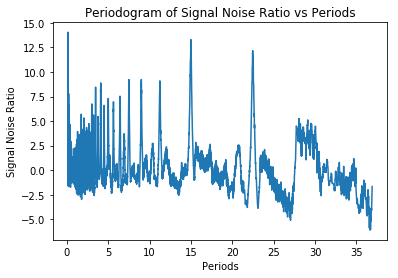

In [4]:
plt.plot(bls.period, bls.snr)
plt.title("Periodogram of Signal Noise Ratio vs Periods")
plt.ylabel("Signal Noise Ratio")
plt.xlabel("Periods")
plt.plot()

### Time vs Flux

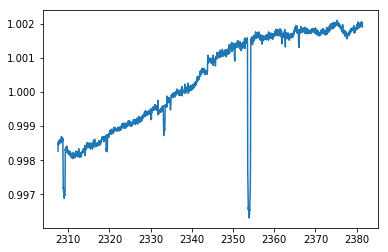

In [5]:
tm=curves.t[0].copy()
tm-=bls.pnew[1]
plt.plot(tm, curves.f[0])

### Time vs Flux at Period

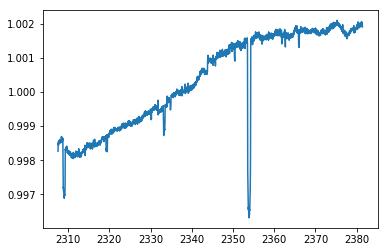

In [6]:
tm=curves.t[0].copy()
plt.plot(tm, curves.f[0])

### Time vs Flux at Period centered

In [7]:
# bls.period[bls.snr > 8]
# Centered around 0
gi

NameError: name 'gi' is not defined

In [8]:
def removeOutliers(x,y, outlierConstant):
    a = np.array(y)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    new_x = []
    new_y = []
    for i in range(len(a.tolist())):
        y = a[i]
        if y > quartileSet[0] and y < quartileSet[1]:
            new_x.append(x[i])
            new_y.append(a[i])
    return np.array(new_x), np.array(new_y)

### Remove Drift

/Users/localhost/Desktop/Projects/Working/CFA/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


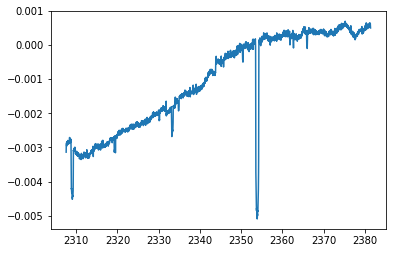

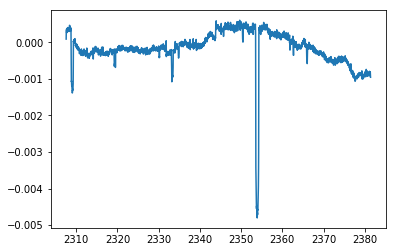

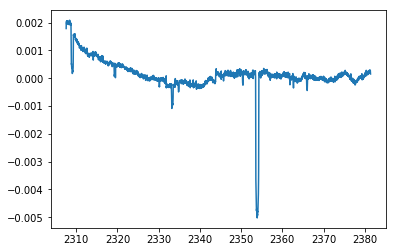

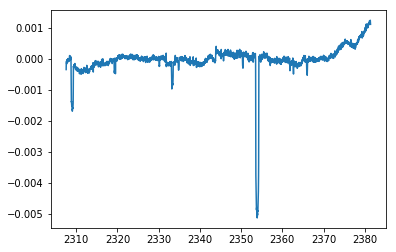

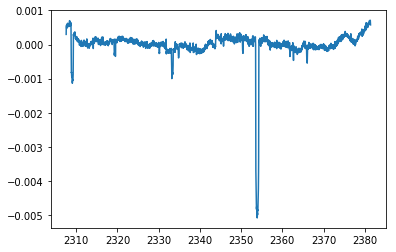

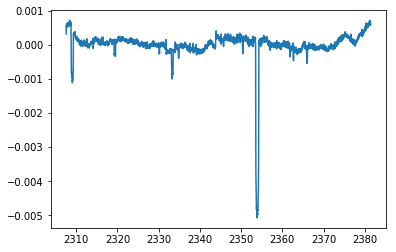

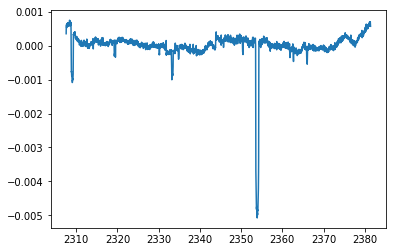

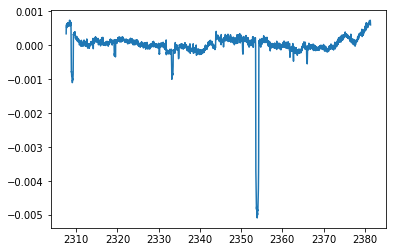

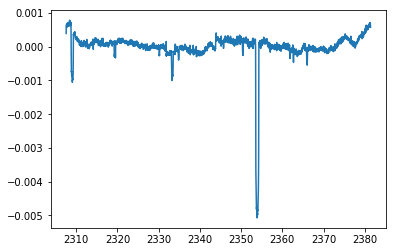

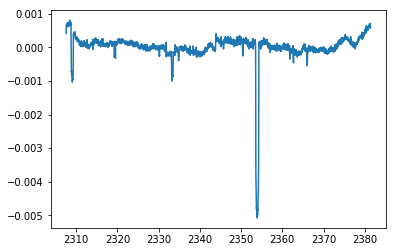

In [9]:
degree = 8
for degree in range(10):
    flux = curves.f[0]
    def fun(c, *args, **kwargs):
        return sum([c*args[0]**e for e,c in zip(c, range(degree))])
    tm = curves.t[0].copy()
    # Remove outliers
    r_tm, r_flux = removeOutliers(tm, flux, .05)
    # Smooth
    smoothed = gaussian_filter1d(r_flux, 2)
    # Fit curve
    model = make_pipeline(PolynomialFeatures(degree), RANSACRegressor())
    model.fit(r_tm.reshape(-1, 1), smoothed)
    trend = model.predict(tm[:, np.newaxis])
    plt.plot(tm, flux-trend)
    plt.show()

Center the periods, then split them into separate periods.
Then change everything to the same length using splines.
For those that don't have complete data, zero out edges.

In [10]:
# Split periods
times = curves.t[0].copy()
flux = curves.f[0] - trend
period = bls.pnew[0]
period=bls.period[bls.snr > 8][100]
t0 = bls.pnew[1]
split_periods = []
split_fluxes = []
i = 0
centered_times = (times-t0-period*.5)%period
while i < len(centered_times)-1:
    c_periods = []
    c_fluxes = []
    while i < len(centered_times)-1 and centered_times[i+1] > centered_times[i]:
        c_periods.append(centered_times[i])
        c_fluxes.append(flux[i])
        i+=1
    i+=1
    split_periods.append(c_periods)
    split_fluxes.append(c_fluxes)

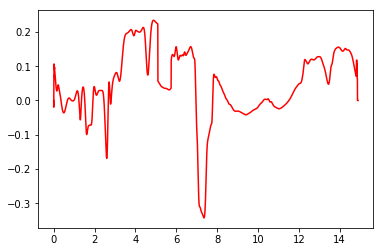

In [13]:
# Create spline and interpolate for each.
interpolated_fluxes = []
resolution = 10000
new_indicies = np.linspace(0, period, resolution)
num_periods = len(split_periods)
counter = np.zeros((num_periods,resolution))+num_periods
for i in range(len(split_periods)):
    spl = UnivariateSpline(split_periods[i], split_fluxes[i], k=5,s=0.000001)
    indicies = 0
    interperted = spl(new_indicies)
    min_val = min(split_periods[i])
    max_val = max(split_periods[i])
    i2 = 0
    while i2 < len(interperted):
        if new_indicies[i2] < min_val:
            interperted[i2] = 0
            counter[i][i2] -= 1
        i2+=1
    i2 = len(interperted)-1
    while i2 >= 0:
        if new_indicies[i2] > max_val:
            interperted[i2] = 0
            counter[i][i2] -= 1
        i2-=1
    interpolated_fluxes.append(interperted)
interpolated_fluxes = np.array(interpolated_fluxes)

interpolated_fluxes = np.array([x/max(abs(x)) for x in interpolated_fluxes]) # Normalize
plt.plot(new_indicies, (interpolated_fluxes/counter).sum(axis=0), 'r')
plt.show()
interpolated_fluxes = []
new_indicies = []

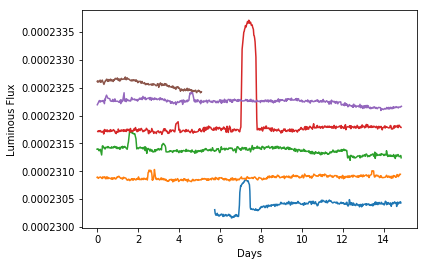

In [32]:
# Centered around 0
offset = 0
for i in range(len(split_fluxes)):
    plt.plot(split_periods[i], spl(split_fluxes[i])+offset)
    offset += np.array(np.array(split_periods).max()).max()/2**25

plt.xlabel("Days")
plt.ylabel("Luminous Flux")
plt.show()

## Light curve histogram

In [ ]:
path_to_campaign='/Users/localhost/Desktop/Projects/Working/CFA/visioneering-deeplearning/experiments/planet_discriminator/local_cache/original_k2_data/curves/c0'
curve_lengths = []
files = [x for x in os.listdir(path_to_campaign) if 'idl' in x]
for i in tqdm(files):
    curve_lengths.append(len(idlsave.read(os.path.join(path_to_campaign, i), verbose=False)['k'].f[0]))

In [ ]:
curve_lengths = pd.DataFrame(np.array(curve_lengths))
curve_lengths.hist()